# Notes on efficiency and parallel processing in python
#### Computational Methods for Geoscience - EPS 400/522
#### Instructor: Eric Lindsey

---------

In [1]:
# some useful imports and settings
import numpy as np
import matplotlib.pyplot as plt
import time
import multiprocessing as mp

%config InlineBackend.figure_format = 'retina' # better looking figures on high-resolution screens

# automatically reload modules when running, otherwise jupyter does not notice if our functions have changed
%load_ext autoreload
%autoreload 2

## Timing and benchmarking

When we process large datasets, it's helpful to first try out the method on a smaller sample so we can check the accuracy and efficiency of our code, instead of waiting days for a result only to find out it's wrong or there was a bug. There are a few important principles here:

- Test your code early and often
- Debug with small samples, not the whole dataset
- Think about execution time and efficiency when writing your code (But don't obsess over it!)

When working on the last point, one typical question we might have is how long a small section of our code takes to run, and whether another option might be faster. We can use the python 'time' library to help us with this.


### Example 1: Filling a matrix with random values

In [2]:
# start the timer - this stores the current time as a floating point value in seconds
tstart = time.time()

#fill up an empty matrix with random numbers, using nested for loops
nx=1000
ny=1000
m=np.zeros((nx,ny))

# loop over the matrix and get a random value for each entry
for i in range(nx):
    for j in range(ny):
        m[i,j]=np.random.randn()

# end the timer
telapsed1 = time.time() - tstart
print('time elapsed with loops: %f seconds' %telapsed1)

# now, let's use the builtin numpy function to do the same thing.

# start the timer
tstart = time.time()

m = np.random.randn(nx,ny)

# end the timer
telapsed2 = time.time() - tstart
print('time elapsed with numpy: %f seconds, %d times faster' %(telapsed2,int(telapsed1/telapsed2)))


time elapsed with loops: 0.654264 seconds
time elapsed with numpy: 0.037260 seconds, 17 times faster


Good to know - not only is the second method much easier to write, we have strong evidence that the builtin numpy function is much faster than using a for loop to fill up a matrix with values. This actually holds true across many builtin functions in python, and even other programming languages, because the code has been *vectorized*. This means it is written to operate on all the elements in a vector or matrix at the same time, rather than one by one. It's a good idea to think about efficiency when writing your code!

### Example 2: Summing over a matrix

In [3]:
# Creating a large 2D array (1000 x 1000) with random numbers
array_2d = np.random.random((1000, 1000))

# We will demonstrate 3 ways to sum up the array.


# Scenario 1: Explicit for loop
start_time = time.time()
sum_forloop = 0

for i in range(array_2d.shape[0]):
    for j in range(array_2d.shape[1]):
        sum_forloop += array_2d[i, j]
        
end_time = time.time()
elapsed_time1 = end_time - start_time
print(f"Time taken for double for loop: {elapsed_time1:.6f} seconds")


# Scenario 2: Half a for loop
start_time = time.time()
sum_halfloop = 0

for j in range(array_2d.shape[0]):
        sum_halfloop += np.sum(array_2d[i, :])
        
end_time = time.time()
elapsed_time2 = end_time - start_time
print(f"Time taken for single for loop: {elapsed_time2:.6f} seconds, {int(elapsed_time1/elapsed_time2)} times faster")


# Scenario 3: Full vectorization
start_time = time.time()

sum_halfloop = np.sum(array_2d[:, :])

end_time = time.time()
elapsed_time3 = end_time - start_time
print(f"Time taken for vectorization:   {elapsed_time3:.6f} seconds, {int(elapsed_time1/elapsed_time3)} times faster")


Time taken for double for loop: 0.225675 seconds
Time taken for single for loop: 0.004824 seconds, 46 times faster
Time taken for vectorization:   0.000535 seconds, 421 times faster


### Example 3: Row vs. Column access to an array

Numpy stores its elements in a "row-major" order, meaning that elements on the same row are stored next to each other in memory.

This means it should be faster to access all the elements within one row at a time, rather than within one column. Let's test it out:

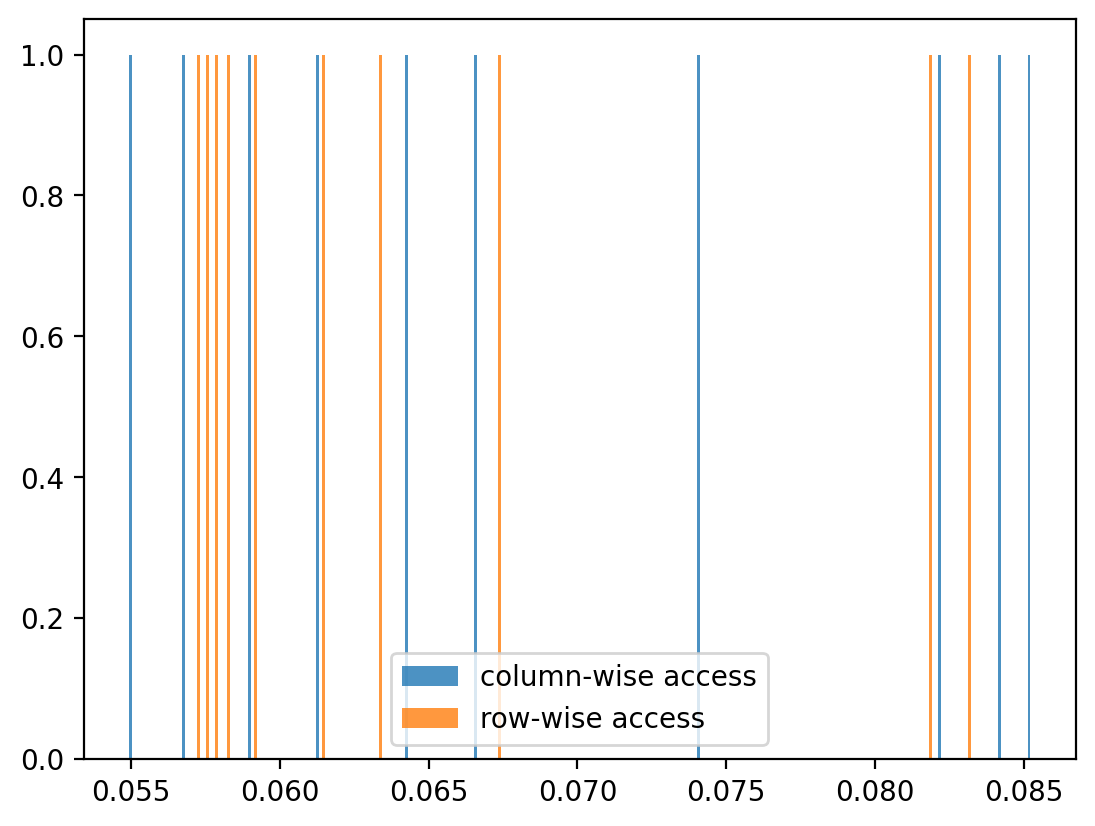

Column access: 0.0688 +/- 0.0111 seconds 
Row access:    0.0648 +/- 0.0094 seconds


In [25]:
ntrials=10
elapsed_time_col=np.zeros((ntrials,1))
elapsed_time_row=np.zeros((ntrials,1))

for k in range(ntrials):
    # Accessing column-wise (non-contiguous memory access)
    array_2d = np.random.random((10000, 10000))
    start_time_col = time.time()
    for j in range(array_2d.shape[1]):
        x = array_2d[:, j]
    end_time_col = time.time()
    elapsed_time_col[k] = end_time_col - start_time_col

    # Accessing row-wise (contiguous memory access)
    array_2d = np.random.random((10000, 10000))
    start_time_row = time.time()
    for i in range(array_2d.shape[0]):
        x = array_2d[i, :]
    end_time_row = time.time()
    elapsed_time_row[k] = end_time_row - start_time_row

w=0.0001
mybins = np.arange(min(min(elapsed_time_row),min(elapsed_time_col)), max(max(elapsed_time_col),max(elapsed_time_row)) + w, w)
# Results
plt.hist(elapsed_time_col,label='column-wise access',alpha=0.8, bins=mybins)
plt.hist(elapsed_time_row,label='row-wise access',alpha=0.8, bins=mybins)
plt.legend()
plt.show()
print('Column access: %.4f +/- %.4f seconds \nRow access:    %.4f +/- %.4f seconds' %(np.mean(elapsed_time_col),np.std(elapsed_time_col),np.mean(elapsed_time_row),np.std(elapsed_time_row)))

I had to run several trials to verify if there is a real difference. In general, I don't see any! Modern Python has implemented some compiler optimizations that reduce this limitation. Good news!

### Example 4: Caching

If we don't re-create the array each time in the above example, Python will cache the values and then all the iterations after the first one will be way faster!

Access times: [[0.01082611 0.00212002 0.00210929 0.0021019  0.0021081  0.0022831 ]]


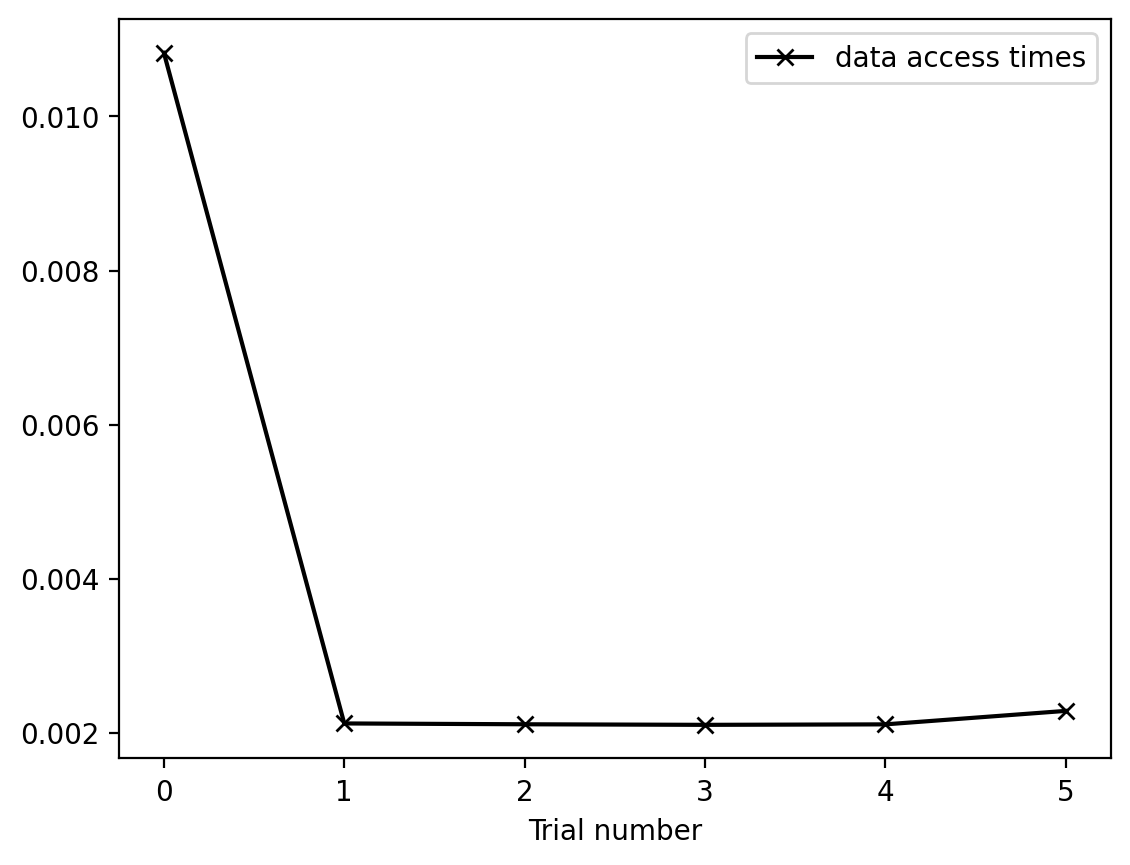

In [17]:
import numpy as np
import time
import matplotlib.pyplot as plt

# We'll create the array here first, allowing Python to cache it inside the for loop:
array_2d = np.random.random((10000, 10000))

ntrials=6
elapsed_time_col=np.zeros((ntrials,1))

for k in range(ntrials):
    # Accessing column-wise (non-contiguous memory access)
    start_time_col = time.time()
    for j in range(array_2d.shape[1]):
        x = array_2d[:, j]
    end_time_col = time.time()
    elapsed_time_col[k] = end_time_col - start_time_col

# Results
print('Access times:', elapsed_time_col.T)
# Results
plt.plot(elapsed_time_col,'-kx',label='data access times')
plt.legend()
plt.xlabel('Trial number')
plt.show()


Note how the first access time is much longer than the others. This indicates Python has been able to cache the array in a faster part of the memory! 

This happens automatically, but it may help to think about how and where you are loading your data, to allow Python to make use of this ability for your own code. For example, if you need to read data from a CSV file, put that outside the for loop instead of inside it!

## Scaling relationships

Another important type of benchmarking involves checking how quickly the execution time increases with some parameter, like number of data points or the matrix size. This allows us to predict the execution time for our full dataset, and check whether it would be feasible. We can use the example above to try this out: 

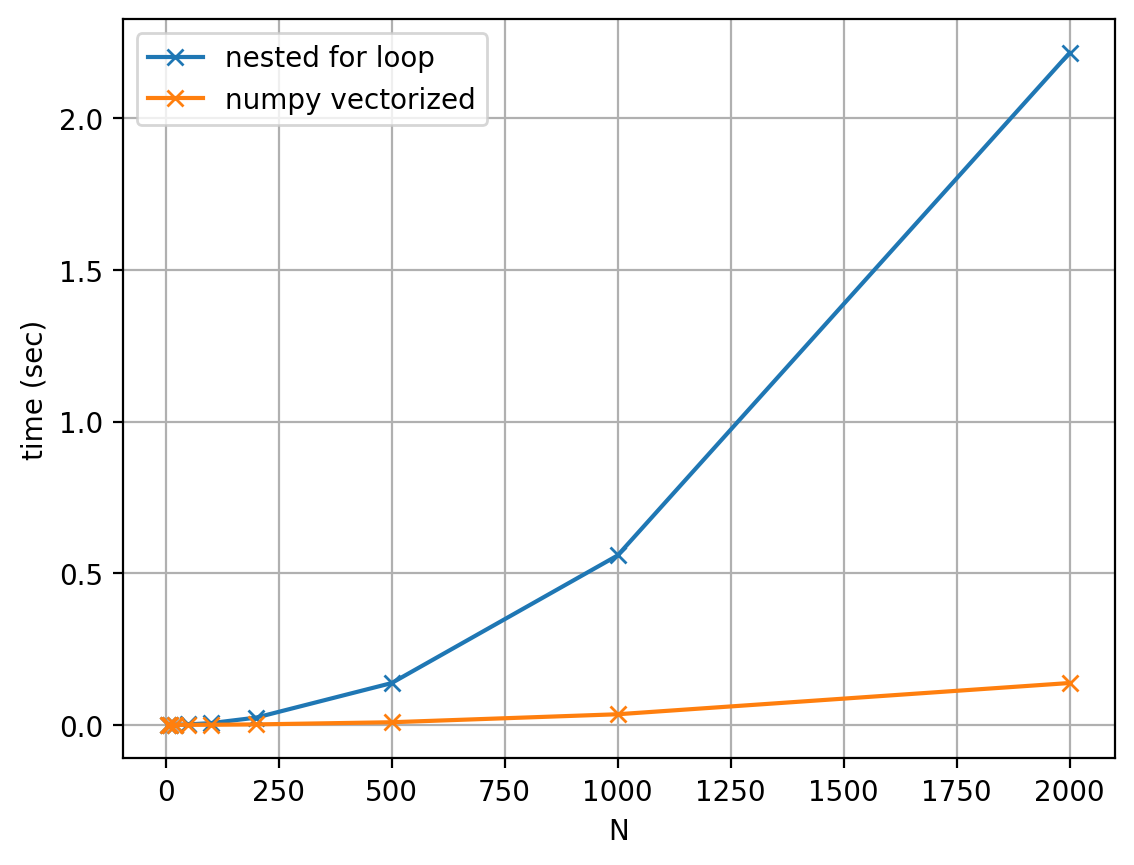

In [18]:
n_list = [2000, 1000, 500, 200, 100, 50, 20, 10, 5]
telapsed1=[];
telapsed2=[];

for n in n_list:
    # time the first method
    tstart = time.time()
    m=np.zeros((n,n))
    # loop over the matrix and get a random value for each entry
    for i in range(n):
        for j in range(n):
            m[i,j]=np.random.randn()
    telapsed1 = np.append(telapsed1, time.time() - tstart)
    
    # time the second method
    tstart = time.time()
    m = np.random.randn(n,n)
    telapsed2 = np.append(telapsed2, time.time() - tstart)

plt.plot(n_list,telapsed1,'-x',label='nested for loop')
plt.plot(n_list,telapsed2,'-x',label='numpy vectorized')
plt.legend()
plt.xlabel('N')
plt.grid()
plt.ylabel('time (sec)')
plt.show()

Very nice, the vectorized method clearly has a big advantage for larger N! But how do the two algorithms scale? Is that quadratic growth, or exponential, or what? Let's plot it in a different way:

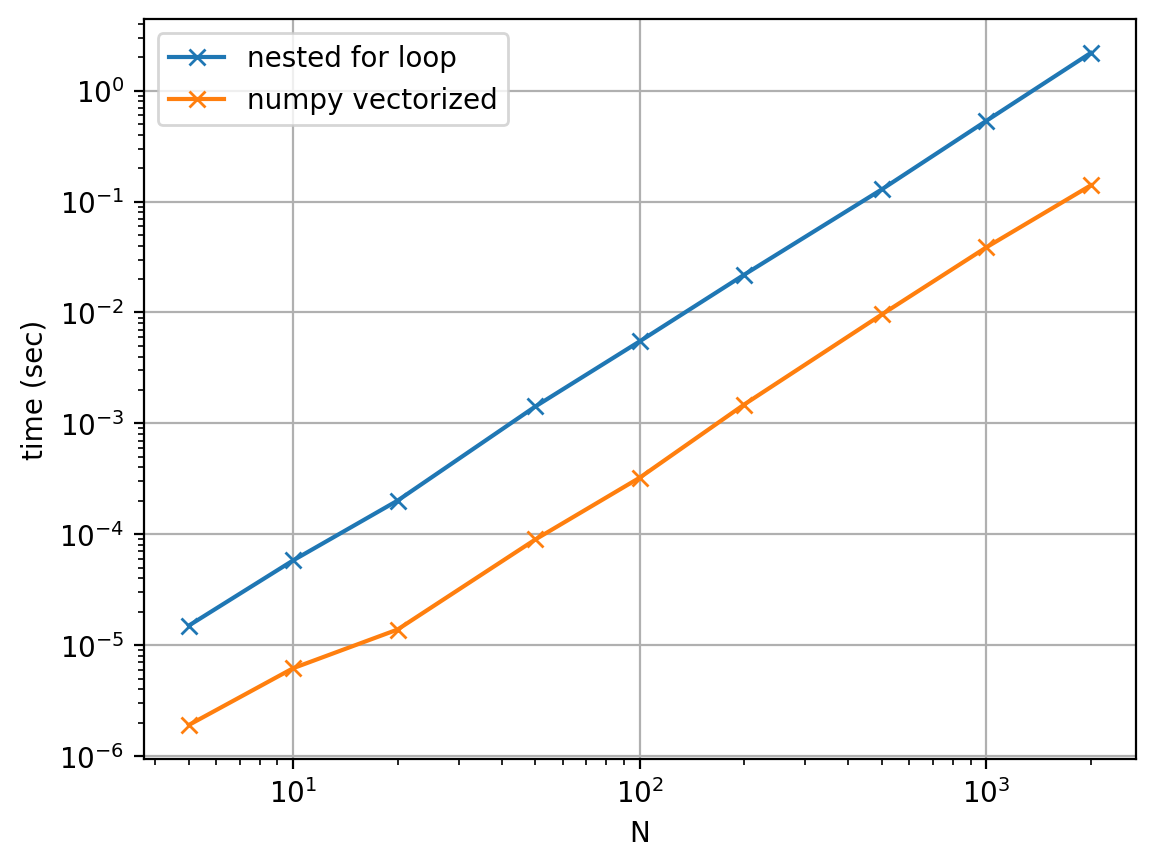

In [7]:
plt.plot(n_list,telapsed1,'-x',label='nested for loop')
plt.plot(n_list,telapsed2,'-x',label='numpy vectorized')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('N')
plt.grid()
plt.ylabel('time (sec)')
plt.show()

Putting both axes on a log scale allows us to see more easily how the values grow with increasing N. There is some noise at small values of N (to be more rigorous, we should run it several times and take an average). But interestingly, we can now see both methods scale in roughly the same way - with a slope of 2. On a log-log plot a slope of 2 means Y is proportional to X^2, which makes sense because the number of matrix elements grows as the square of N. So the nested for loop is about 10-15 times slower than the builtin function, but this ratio does not get any worse (or better) with larger values of N.

## Parallel Processing

Sometimes, our task is simply too large to speed up with clever programming. Fortunately, in such a case we can take advantage of multiple cores to run things in parallel. Most modern computers (including laptops) have at least 2-8 cores within their CPU that can run separate tasks simultaneously, and if we move to a desktop or high-performance computing system, 32-64 cores per computer is not uncommon. 

Beyond that number, we can also consider more complex systems that use GPUs with thousands of cores, or that efficiently connect CPUs between multiple computers networked together, though this is outside the scope of our work here.

To run a simple parallel job in Python, we'll use the 'multiprocessing' library. A key thing to note about this library is that it requires us to put the functions we want to run in a separate file, rather than inside the jupyter notebook. This is unfortunate but necessary!

Parallel processing works best when we have many identical tasks to run, each of which can be specified by a simple parameter that takes on a range of values. For example, say we wanted to compute the factorial of a series of numbers. The result for each number is independent of all the others, which is ideal for parallel processing. Then we can simply create a "pool" of workers that draw from the list of values to be run, and execute the code for that value.

In [8]:
# import the multiprocessing library
import multiprocessing as mp

# we put our functions in this separate file - this should be placed in the same folder where you are running this notebook.
import parallelTest

tstart = time.time()
# how many cores?
num_cores = 4
pool = mp.Pool(num_cores)

# run the test for all values between 1 and 5000 
# (note, np.arange will provide an array that stops one before the end value, so e.g. we give it 101 to stop at 100)
results = pool.map(parallelTest.getFactorial, np.arange(1,5001))

# end the timer
telapsed = time.time() - tstart
print('time elapsed with %d cores: %f seconds' %(num_cores, telapsed))


time elapsed with 4 cores: 0.889202 seconds


Great, we are running in parallel! Let's make a similar scaling plot to see how things improve with more cores, so we can choose the optimal number.

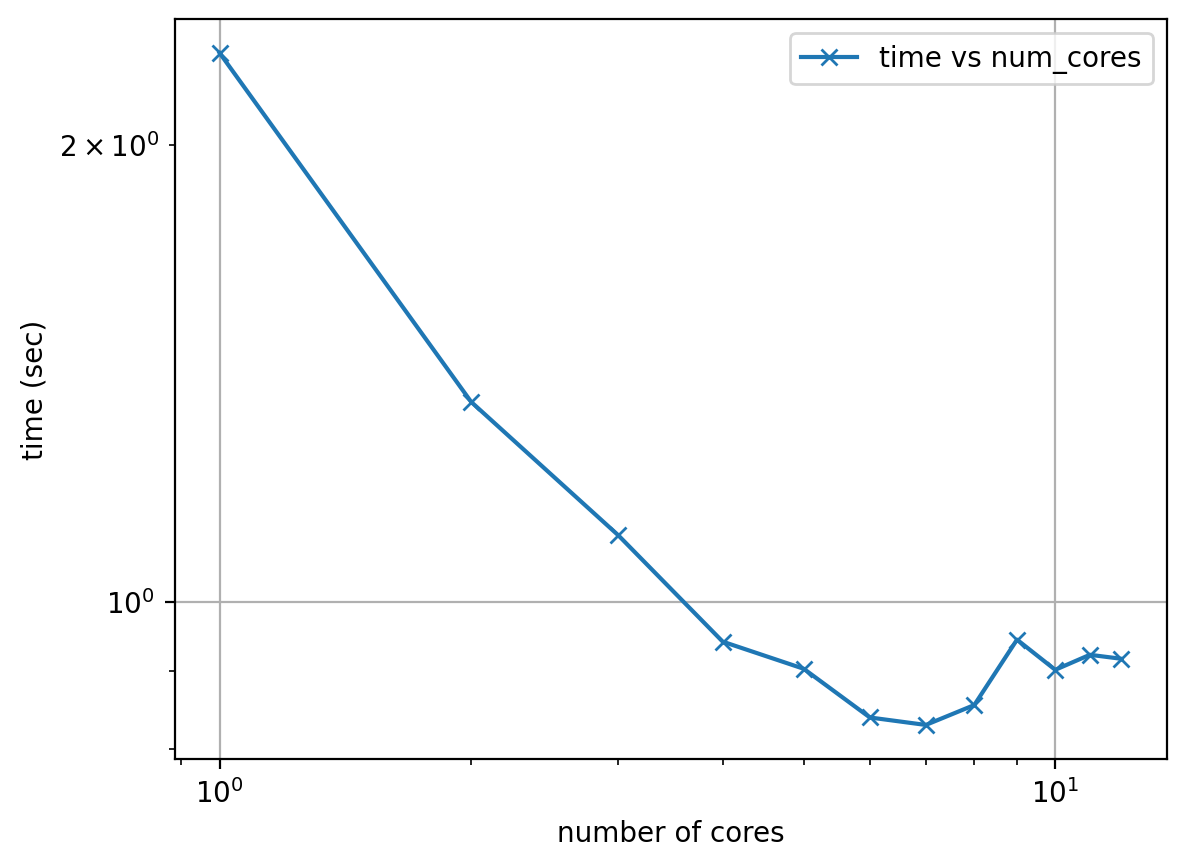

In [26]:
n_list=range(1,13)
telapsed=[];

for num_cores in n_list:
    tstart = time.time()
    pool = mp.Pool(num_cores)
    # our test function gets the factorial of every number in a list - here, the integers between 1 and 5000!
    results = pool.map(parallelTest.getFactorial, np.arange(1,5001))
    telapsed = np.append(telapsed, time.time() - tstart)

plt.plot(n_list,telapsed,'-x',label='time vs num_cores')

plt.legend()
plt.xlabel('number of cores')
plt.grid()
plt.yscale('log')
plt.xscale('log')
plt.ylabel('time (sec)')
plt.show()

On my laptop, I don't really get any speedup after 8 cores, because my laptop only has 8 cores! Actually, the best number in this case is usually 7 because my 8th core might be busy running the operating system. Beyond this point, any extra "workers" have to share the same resources and there is no additional speedup. In fact, the time actually starts to increase, because the various workers are competing with each other for resources and causing additional overhead - the CPU is spending more time switching between tasks and less time actually running them!